# Classification

In [1]:
#!/usr/bin/env python3

# Basic import
import numpy as np
import matplotlib.pyplot as plt

# Pytorch import
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset, Subset
from torchvision import transforms, datasets
import torch.nn.functional as F

# Import models and training functions
from models import ConvNet, FFNet
from training import train_epochs, train_epochs_acc, kf_train_epochs
from functions import my_accuracy

# Import progress bars
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from time import sleep

#Import sys
import sys





## Dataset and Dataloader

In [2]:
### Dataset

dataset = datasets.MNIST('MNIST', train = True, download = True,
                             transform = transforms.Compose([
                               transforms.ToTensor(),
                                transforms.Normalize(0.0, 1.0, inplace=True)
                             ]))

test_data = datasets.MNIST('MNIST', train = False, download = True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                                 transforms.Normalize(0.0, 1.0, inplace=True)
                             ]))

# Divide data dataset in train dataset and val dataset
train_data, val_data = torch.utils.data.random_split(dataset, [50000, 10000])

In [3]:
### Dataloaders
batch_size = 128
train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=0)
val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size = 1, shuffle=True, num_workers=0)

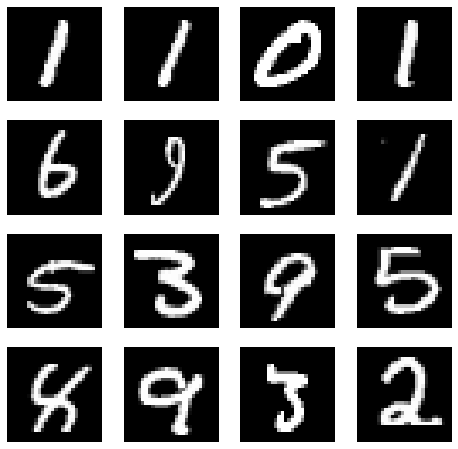

In [4]:
# Plot Mnist
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(1,cols * rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Training

In [5]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


### Stocahstic Gradient Descent

In [10]:
# Define the networks
filename = "ConvNet_sgd.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

Network initialized


ConvNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [11]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.0, weight_decay = 0.0)


In [12]:
# Training 
max_num_epochs = 20
early_stopping = False
train_loss_sgd, val_loss_sgd, accuracy_sgd = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)

  0%|          | 0/20 [00:00<?, ?it/s]

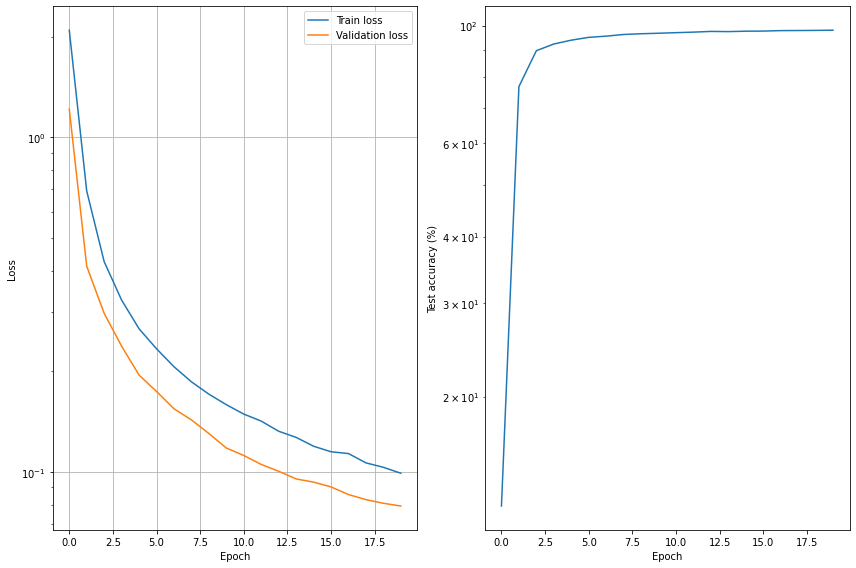

In [14]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_sgd, label='Train loss')
ax1.semilogy(val_loss_sgd, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_sgd, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [15]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### SGD with momentum

In [25]:
# Define the networks
filename = "ConvNet_sgdmom.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

Network initialized


ConvNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [26]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.0)


In [27]:
# Training 
max_num_epochs = 20
early_stopping = False
train_loss_sgdmom, val_loss_sgdmom, accuracy_sgdmom = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


  0%|          | 0/20 [00:00<?, ?it/s]

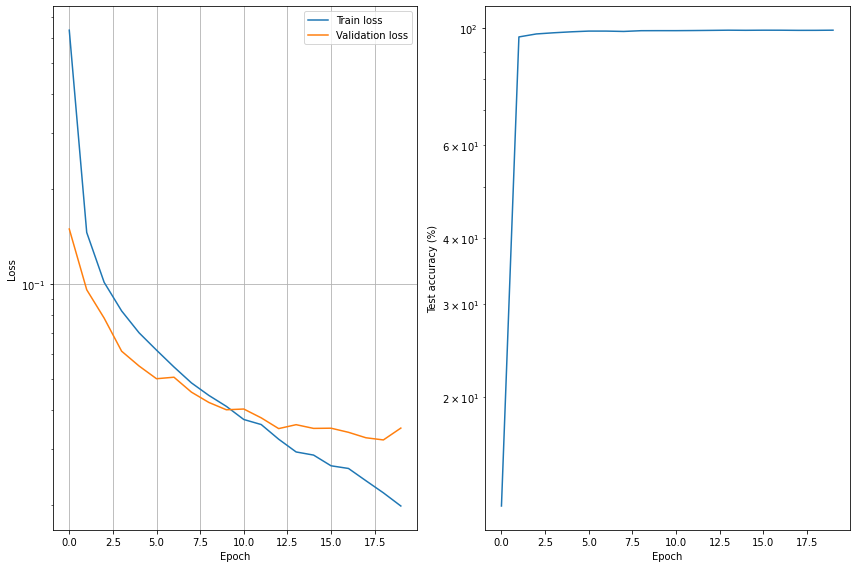

In [28]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_sgdmom, label='Train loss')
ax1.semilogy(val_loss_sgdmom, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_sgdmom, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [29]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### RMSprop

In [30]:
# Define the networks
filename = "ConvNet_rmsprop.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

Network initialized


ConvNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [31]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.RMSprop(net.parameters(), lr = 0.01, momentum = 0.0, weight_decay = 0.0)


In [32]:
# Training 
max_num_epochs = 20
early_stopping = False
train_loss_rmsprop, val_loss_rmsprop, accuracy_rmsprop = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)

  0%|          | 0/20 [00:00<?, ?it/s]

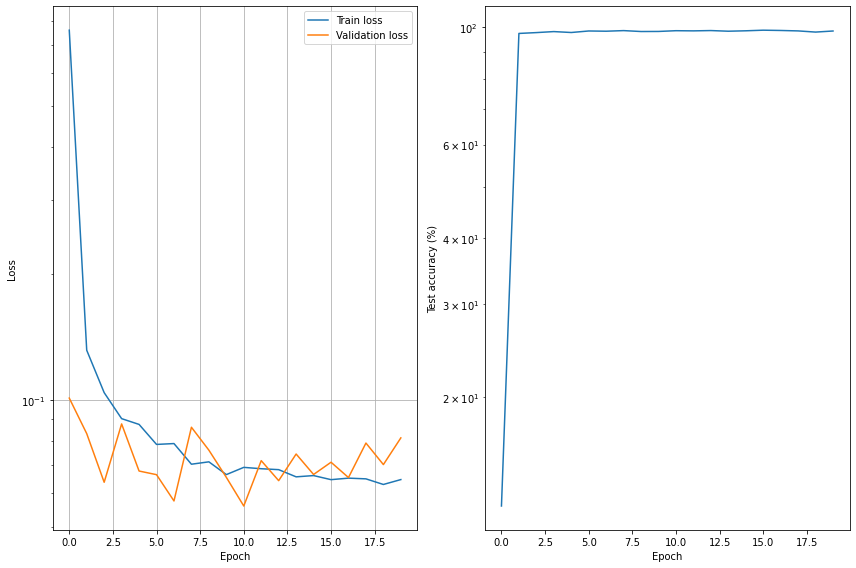

In [33]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_rmsprop, label='Train loss')
ax1.semilogy(val_loss_rmsprop, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_rmsprop, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [34]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### Adam

In [73]:
# Define the network
filename = "ConvNet_adam.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

Network initialized


ConvNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [74]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.0)


In [75]:
# Training 
max_num_epochs = 20
early_stopping = False
train_loss_adam, val_loss_adam, accuracy_adam = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


  0%|          | 0/20 [00:00<?, ?it/s]

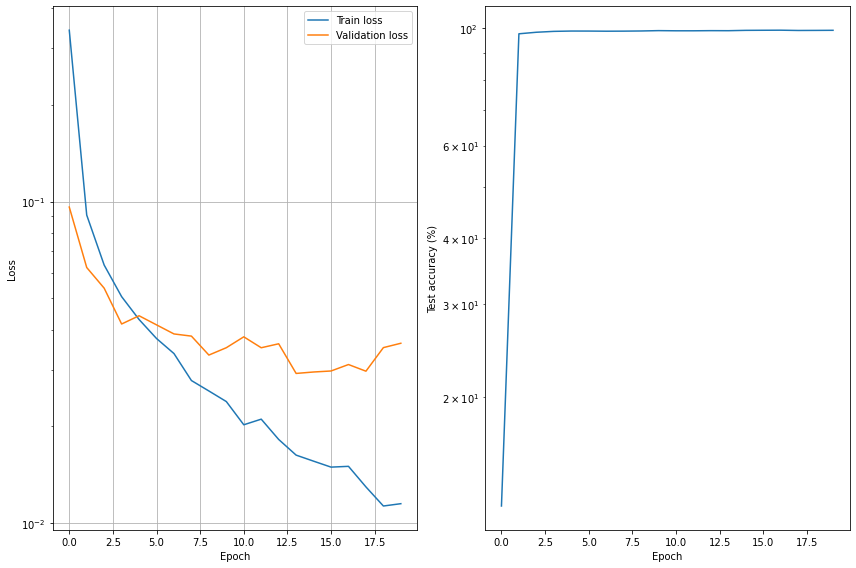

In [76]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_adam, label='Train loss')
ax1.semilogy(val_loss_adam, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_adam, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [77]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### Adam with L2 regularization

In [79]:
# Define the network
filename = "ConvNet_adamL2.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

Network initialized


ConvNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [80]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 0.1)


In [81]:
# Training 
max_num_epochs = 20
early_stopping = False
train_loss_adamL2, val_loss_adamL2, accuracy_adamL2 = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


  0%|          | 0/20 [00:00<?, ?it/s]

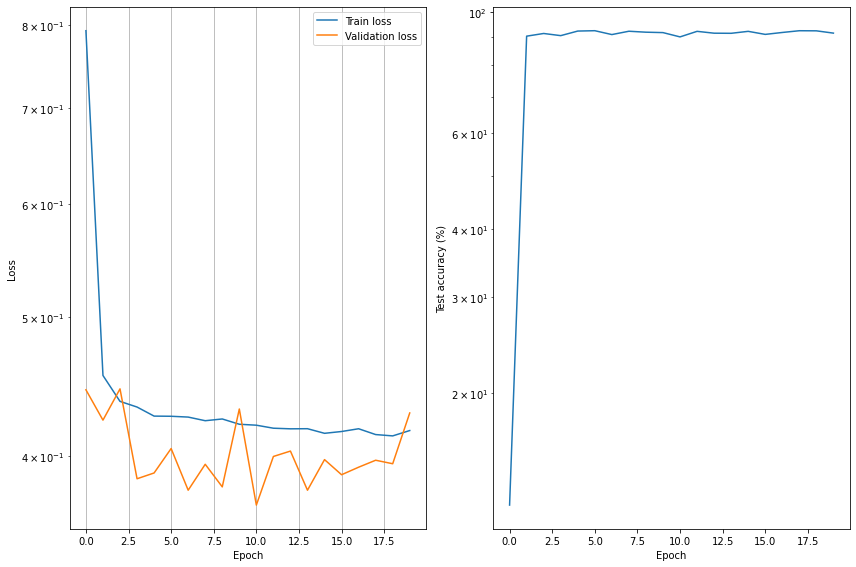

In [82]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_adamL2, label='Train loss')
ax1.semilogy(val_loss_adamL2, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_adamL2, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [83]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### Adagrad

In [67]:
# Define the network
filename = "ConvNet_adagrad.torch"
parameters = {
    "act" : nn.ReLU, 
    "drop_p" : 0.1,
}

# Inizialize the network
torch.manual_seed(0)
net = ConvNet(parameters)
net.to(device)

Network initialized


ConvNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.1, inplace=False)
  )
  (lin): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [68]:
# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adagrad(net.parameters(), lr = 0.1, lr_decay = 0.1, weight_decay = 0.0)


In [69]:
# Training 
max_num_epochs = 20
early_stopping = False
train_loss_adagrad, val_loss_adagrad, accuracy_adagrad = train_epochs_acc(net, device, train_dataloader, val_dataloader, test_dataloader, loss_function, optimizer, max_num_epochs, early_stopping = early_stopping)


  0%|          | 0/20 [00:00<?, ?it/s]

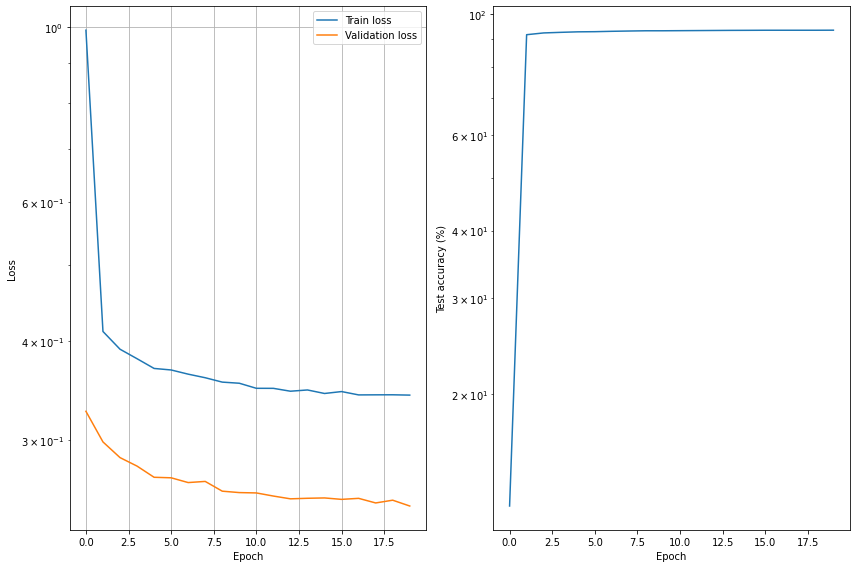

In [70]:
### Plot losses
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(121)
ax1.semilogy(train_loss_adagrad, label='Train loss')
ax1.semilogy(val_loss_adagrad, label='Validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.semilogy(accuracy_adagrad, label = "Test accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Test accuracy (%)")

plt.tight_layout()
plt.show()

In [71]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_dict = { "state" : net.state_dict(),
            "parameters" : parameters}
# Save the state dict to a file
torch.save(net_dict,filename)


### Comparision

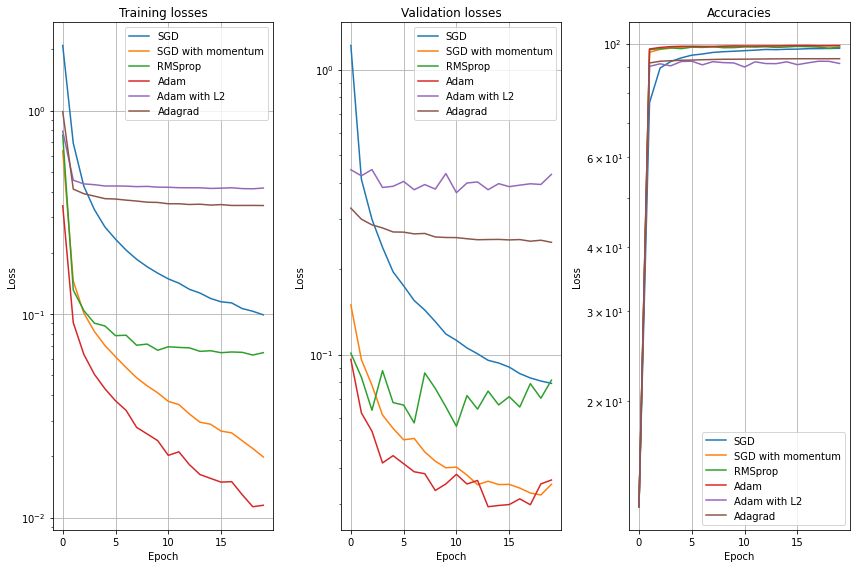

In [84]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(131)
ax1.set_title("Training losses")
ax1.semilogy(train_loss_sgd, label='SGD')
ax1.semilogy(train_loss_sgdmom, label='SGD with momentum')
ax1.semilogy(train_loss_rmsprop, label='RMSprop')
ax1.semilogy(train_loss_adam, label='Adam')
ax1.semilogy(train_loss_adamL2, label='Adam with L2')
ax1.semilogy(train_loss_adagrad, label='Adagrad')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(132)
ax2.set_title("Validation losses")
ax2.semilogy(val_loss_sgd, label='SGD')
ax2.semilogy(val_loss_sgdmom, label='SGD with momentum')
ax2.semilogy(val_loss_rmsprop, label='RMSprop')
ax2.semilogy(val_loss_adam, label='Adam')
ax2.semilogy(val_loss_adamL2, label='Adam with L2')
ax2.semilogy(val_loss_adagrad, label='Adagrad')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid()
ax2.legend()


ax3 = fig.add_subplot(133)
ax3.set_title("Accuracies")
ax3.semilogy(accuracy_sgd, label='SGD')
ax3.semilogy(accuracy_sgdmom, label='SGD with momentum')
ax3.semilogy(accuracy_rmsprop, label='RMSprop')
ax3.semilogy(accuracy_adam, label='Adam')
ax3.semilogy(accuracy_adamL2, label='Adam with L2')
ax3.semilogy(accuracy_adagrad, label='Adagrad')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.grid()
ax3.legend()

plt.tight_layout()
plt.show()

# Network analysis

In [51]:
### Load network state
filename = "ConvNet_sgdmom.torch"

# Load the state dict previously saved
net_dict = torch.load(filename)
net_state_dict = net_dict["state"]
net_parameters_dict = net_dict["parameters"]

# Redefine the network and upload parameters
net = ConvNet(net_parameters_dict)
net.load_state_dict(net_state_dict)

Network initialized


<All keys matched successfully>

## Accuracy
    
    

In [52]:
### Compute accuracy of the model
mismatched, confusion, acc = my_accuracy(net, device, test_dataloader)
print("Test accuracy: ", acc, "%")

Test accuracy:  99.19 %


### Plot mismatched numbers


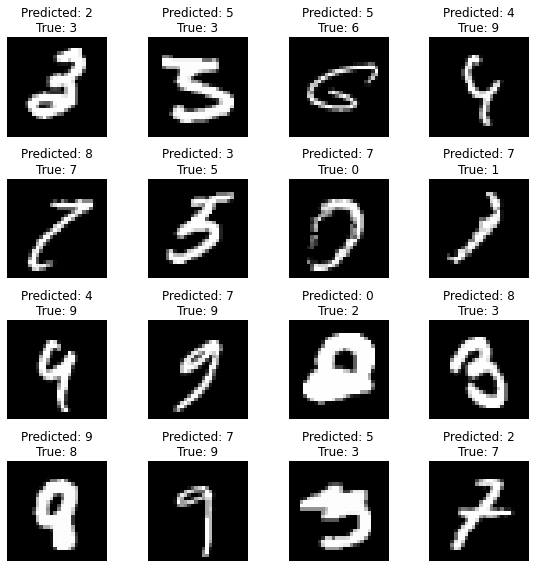

In [53]:
# Plot Mismatched numbers
figure = plt.figure(figsize=(8, 8))
cols, rows = 4,4


for i in range(rows*cols):
    img = mismatched[i][0]
    
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray"  )
    plt.title("Predicted: "+str(mismatched[i][1])+"\n"+"True: "+str(mismatched[i][2]))
    
plt.tight_layout()
plt.show()

### Confusion matrix

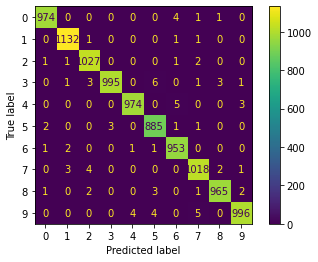

In [54]:
### Build the confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

# Get predictions and ground trues
trues = confusion[0]
predictions = confusion[1]

# Compute and plot confusion matrix
cm = confusion_matrix(trues, predictions, labels =np.array(range(10)) )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = np.array(range(10)))
disp.plot()
plt.show()


## Network parameters 

In [55]:
# Access convolution network parameters

dense_weight = net.lin[0].weight.data.cpu().numpy()
dense_bias = net.lin[0].bias.data.cpu().numpy()
out_weight = net.lin[3].weight.data.cpu().numpy()
out_bias = net.lin[3].bias.data.cpu().numpy()

### Convolution filtered images

In [56]:
# Acces convolution filters
conv1 = net.cnn[0].weight.data.cpu()
conv2 = net.cnn[4].weight.data.cpu()

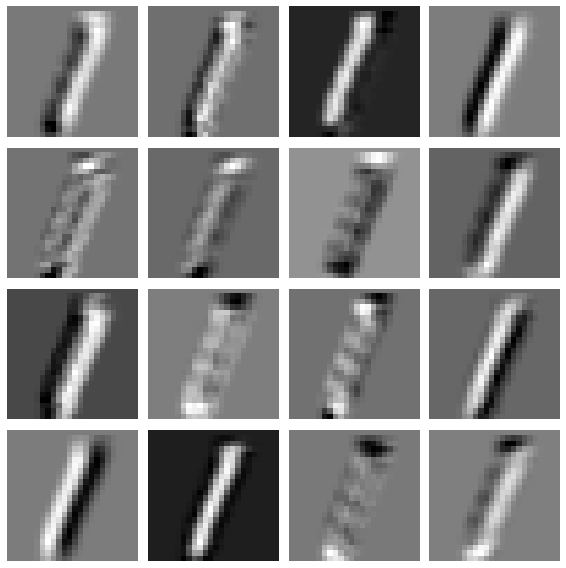

In [57]:
### First convolution filter
fig = plt.figure(figsize=(8, 8))
cols, rows = 4,4

# Take an image and apply convolution
img, label = train_data[0]
img = F.conv2d(img.unsqueeze(dim=0), conv1)


# Plot filtered images

for i in range(16):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    #plt.title("Filter %d" %(i+1))
    plt.imshow(img.squeeze().numpy()[i], cmap="gray")
    
plt.tight_layout()
plt.show()




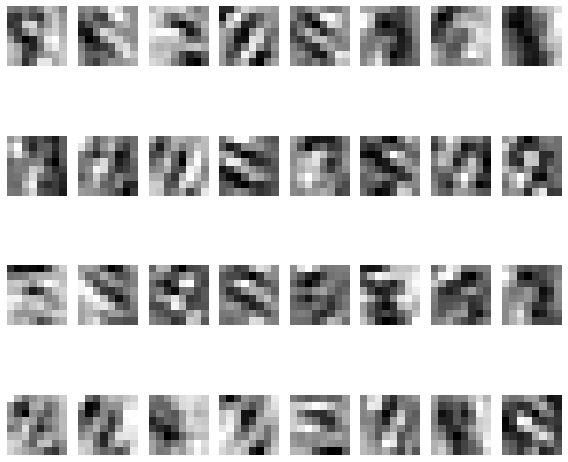

In [58]:
### Second convolution filter
fig = plt.figure(figsize=(8, 8))
cols, rows = 8,4

# Take an image and apply convolution
img, label = train_data[9]
img = F.conv2d(img.unsqueeze(dim=0), conv1)
img = F.relu(img)
img  = F.max_pool2d(img, kernel_size = 2)
img = F.conv2d(img, conv2)

# Plot filtered images

for i in range(32):
    fig.add_subplot(rows, cols, i+1)
    plt.axis("off")
    #plt.title("Filter %d" %(i+1))
    plt.imshow(img.squeeze().numpy()[i], cmap="gray")
    
plt.tight_layout()
plt.show()